<a href="https://colab.research.google.com/github/kasvinatirumal/wdrp_wi25/blob/main/Pricing_European_Call_Options.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Pricing European Call Options for the Top 5 S&P 500 Stocks using the Black-Scholes Equation

Ensure that the file `call_options_analysis.csv` is downloaded and uploaded onto this space before running this file.

This project aims to explore the following research questions:
1. How can stock prices be modeled mathematically?
1. How can the historical volatility of stocks be estimated?
1. How can European call options be priced using **historical volatility**, and how does this estimation compare to the market price?
1. How can European call options be priced using **implied volatility**, and how does it differ from using **historical volatility**?
1. Is the volatility smile observable in real-world call options?






In [1]:
!pip install -q yahoo_fin

In [2]:
from yahoo_fin import options
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime
import math
from scipy.stats import norm
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from google.colab import files

In [3]:
# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### RQ1: How can stock prices be modeled mathematically?

We start by importing a dataset containing Microsoft stock data for 2024, and visualizing the stock price movement using a line chart.

In [4]:
ticker = "MSFT"
msft_info = yf.download(ticker, start="2024-01-01", end="2024-12-31", progress=False)
msft_price = msft_info['Close'].reset_index()
msft_price.columns = ['Date', 'Close']
print(f"Number of Trading Days:{len(msft_price)}")

YF.download() has changed argument auto_adjust default to True
Number of Trading Days:251


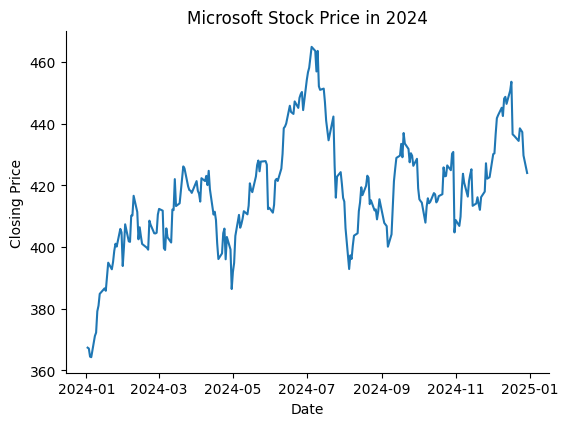

In [5]:
# visualize Mircrosft stock price movement
plot = sns.relplot(data=msft_price, x="Date", y="Close", kind="line")
plot.set(ylabel="Closing Price", title="Microsoft Stock Price in 2024");
plot.fig.set_size_inches(6, 4)

The line graph above illustrates the movement of Microsoft's stock price over the 251 trading days in 2024. Notice the significant fluctuations in stock price. By viewing these fluctuations as **random noise**, we can model stock price movement mathematically using a stochastic (random) process, known as **Geometric Brownian Motion**.

Formally, a stochastic process is said to follow a Geometric Brownian Motion (GBM), if it satisfies the following stochastic differential equation:
$$
dS_t = \mu S_t dt + \sigma S_t dW_t
$$
The variables above are as follows:
- $S_t$: Stock price at time $t$
- $\mu$: Percentage drift/ Expected rate of return on stock
- $\sigma$: Historical volatility
- $dW_t$: Brownian motion

Next, we define $Z_t$ as $Z_t = ln(S_t)$.
As a result, the above general form can be rewritten as follows:
$$
dZ_t = \left(\mu -\frac{1}{2}\sigma^2 \right) dt + \sigma dW_t
$$

This implies that $dZ_t$ follows the follwing normal distribution:
$$
Z_{t+\Delta t} - Z_t \sim N\left(\mu - \frac{1}{2}\sigma^2 \Delta t, \sigma^2 \Delta t \right)
$$

Using the above general form, we can model stock price movement by choosing $\Delta t$ as $1/251$, since there were 251 trading days in 2024:
$$
Z_{\frac{i+1}{251}} - Z_{\frac{i}{251}} \sim N \left(\mu_{\text{daily}}, \sigma_{\text{daily}}^2\right) \tag{1}
$$
$$
Z_{\frac{i+1}{251}} - Z_{\frac{i}{251}} \sim N \left(\mu_{\text{annual}} - \frac{1}{2}\left(\frac{\sigma_{\text{annual}}^2}{251}\right), \ \frac{\sigma_{\text{annual}}^2}{251} \right) \tag{2}
$$

### RQ2: How can the historical volatility of stocks be estimated?

Using the derived model, we can now estimate the historical volatility of stocks $\sigma$, by first calculating the daily log returns of stock as follows:

In [6]:
# log returns: Z_t = ln(S_t)
msft_price['log_returns'] = np.log(msft_price['Close']) - np.log(msft_price['Close'].shift(1))
msft_price.head()

,Date,Close,log_returns
0,2024-01-02,367.380585,NaN
1,2024-01-03,367.113159,-0.000728
2,2024-01-04,364.478180,-0.007203
3,2024-01-05,364.289978,-0.000516
4,2024-01-08,371.164673,0.018696


Next,to **estimate annual drift and volatility**, we utilize the following equations, obtained by setting the paramters within the distribution in (1) and (2) equal to each other:
\begin{align*}
\mu_{\text{annual}} &= \mu_{\text{daily}} + \frac{1}{2}\left(\frac{\sigma_{\text{daily}}^2}{251} \right) \\
\sigma_{\text{annual}} &= \sigma_{\text{daily}}\sqrt{251}
\end{align*}

In [7]:
drift_daily = msft_price["log_returns"].mean()
vol_daily = msft_price["log_returns"].std()

annual_drift = drift_daily + (0.5 * vol_daily**2) / 251
annual_vol = vol_daily * np.sqrt(251)

print("Estimated Annualized Values for 2024:")
print(f"Percentage Drift: {round(annual_drift, 6)}")
print(f"Historic Volatility: {round(annual_vol, 6)}")

Estimated Annualized Values for 2024:
Percentage Drift: 0.000573
Historic Volatility: 0.200385


### RQ3: How can European call options be priced using **historical volatility**, and how does this estimation compare to the market price?

#### Data Loading & Preparation
To price European call options, call option data was imported for stocks of the top five S&P 500 companies from Yahoo Finance, which includes: Apple, Nvidia, Microsoft, Amazon, and Meta. The resulting dataset, after cleaning and transformation, is named `calls_df`.

In [8]:
stocks = ["AAPL", "NVDA", "MSFT", "AMZN", "META"]

# # creates a Ticker object for the top 5 S&P 500 Companies
# aapl = yf.Ticker("AAPL") # Apple
# nvda = yf.Ticker("NVDA") # NVIDIA
# msft = yf.Ticker("MSFT") # Microsoft
# amzn = yf.Ticker("AMZN") # Amazon
# meta = yf.Ticker("META") # Meta

# # gets expiration_dates for options
# exp_dates = aapl.options

# date_six_month_ltr = datetime.today().replace(month=(datetime.today().month + 6) % 12)
# exp_date = next(date for date in exp_dates if date >= date_six_month_ltr.strftime("%Y-%m-%d"))
# print(f"Expiration Date: {exp_date}")

In [9]:
# calls_df = options.get_calls("AAPL", exp_date)
# for stock in stocks[1:]:
#     df = options.get_calls(stock, exp_date)
#     calls_df = pd.concat([calls_df, df])

In [10]:
# calls_df["Trade Date"] = pd.to_datetime(calls_df["Last Trade Date (EST)"], format="%m/%d/%Y %I:%M %p").dt.date
# calls_df["Months to Exp"] = ((pd.to_datetime(exp_date) - pd.to_datetime(calls_df["Trade Date"])).dt.days / 30).astype(int)
# calls_df["Implied Volatility"] = calls_df["Implied Volatility"].str[:-1].astype(float)/100
# calls_df = calls_df[calls_df["Implied Volatility"] != 0]
# calls_df = calls_df.reset_index().drop(columns=["index", "Last Trade Date (EST)", "Change", "% Change", "Volume", "Open Interest"])
# calls_df.to_csv("call_options.csv", index=False)

In [11]:
calls_df = pd.read_csv("call_options_analysis.csv")
calls_df.sample(n=5)

,Contract Name,Strike,Last Price,Bid,Ask,Implied Volatility,Trade Date,Months to Exp
35,AAPL250919C00210000,210,42.94,42.60,42.80,0.3663,2025-03-03,6
306,AMZN250919C00185000,185,36.82,36.85,37.10,0.4208,2025-02-28,6
438,META250919C00670000,670,77.39,75.70,76.20,0.4094,2025-03-03,6
166,NVDA250919C00214000,214,1.98,1.53,1.57,0.5314,2025-02-28,6
191,NVDA250919C00280000,280,0.49,0.45,0.47,0.5640,2025-03-03,6


Now that we have our dataset, we can move on to pricing the call options using the Black Scholes Formula for European Call Options, which states: The price of a European Call Option wth strike price $K$ and time of maturity $T$ is given by the formula $\Pi(t) = F(t, S(t))$, where: \\

$$F =  S \cdot N[d_1(t, s)] - e^{−r(T-t)} \cdot K \cdot N[d_2(t, s)] \tag{3}$$

$N$ is the cumulative distribution function for the $N[0,1]$ distribution, and: \\
\begin{align*}
d_1(t, s) &= \frac{1}{\sigma \cdot \sqrt{T-t}} \cdot \left[ln\left(\frac{S}{K}\right) + \left(r + \frac{1}{2}\sigma^2\right) \cdot (T-t)\right]\\
\\
d_2(t, s) &= d_1(t, s) - \sigma \cdot \sqrt{T-t}
\end{align*}

The variables above are as follows:
- $K$: Strike price in US dollars
- $S$: Stock price in US dollars
- $T-t$: Time to expiration in number of years
- $r$: Risk-free rate (based on return on US treasury bills)
- $\sigma$: Implied volatility
- $F$: Final price of option


Using (3), we can write the following function to estimate the theorectical price for each call option in the dataset `calls_df`.

In [12]:
def calc_call_option_price(S, K, T, r, v):
  d1 = (math.log(S/K) + (r + 0.5 * v**2) * T) / (v * math.sqrt(T))
  d2 = d1 - v * math.sqrt(T)
  F = S * norm.cdf(d1) - math.exp(-r * T) * K * norm.cdf(d2)
  return F

Next, we set up the other variables needed to estimate the theorectical price, including the underlying stock price of each option for the given trade date in each row $S$, interest rate $r$, and historical volatility for each stock type $\sigma$.

#### Stock Price for each Call Option

In [13]:
def get_monthly_stock_data(ticker, trade_date):
    year_month = trade_date.strftime("%Y-%m")

    # Download monthly stock data
    stock_data = yf.download(ticker, start=f'{year_month}-01', end=f'{year_month}-28', interval='1mo', progress=False, auto_adjust=True)

    if not stock_data.empty:
        return stock_data["Close"].iloc[-1]  # Last trading day of the month
    else:
        return None

In [14]:
calls_df['Stock_Abbv'] = calls_df['Contract Name'].str[:4]
calls_df["Trade Date"] = pd.to_datetime(calls_df["Trade Date"])

In [15]:
stock_prices = []
for index, row in calls_df.iterrows():
    ticker = row["Stock_Abbv"]
    price = get_monthly_stock_data(ticker, row["Trade Date"])[ticker]
    stock_prices.append(price)

calls_df["Stock Price"] = stock_prices.copy()

#### Interest Rate
First off, we choose the interest rate $r$, to be 0.0434, which corresponds to the current return rate of a **6-month treasury bill**. A 6-month treasury bill was chosen because the earliest call option expiration within our dataset is in six months.

However, our **current choice of $r$ is discrete**, but we **require a continuous $r$** for the Black-Scholes Equation.

Given that we assume a constant time to expiration of 6 months, we can set $t=\frac{6}{12} =\frac{1}{2}\text{years}$. This leads to the following conversion:

\begin{align*}
e^{r_{cont} t} &= 1 + r_{discrete} \\
e^{\frac{r_{cont}}{2}} &= 1 + r_{discrete} \\
r_{cont} &= 2\ln\left(1+\frac{r_{discrete}}{2}\right) \tag{4}
\end{align*}

Using (4), we can now compute our continuous interest rate, `r_cont` as follows:

In [16]:
r_discrete = 0.0434
r_cont = 2 * math.log(1+r_discrete/2)

#### Historical Volatility

Using the formula derived to answer RQ2, we compute the historical volatility for each stock type, and add it as a new column, `Hisotical Volaility`, to the `calls_df` dataset.

In [17]:
hist_vol = {}

def calc_historic_vol(stock):
  info = yf.download(stock, start="2024-01-01", end="2024-12-31", progress=False)
  price = info['Close'].reset_index()
  price.columns = ['Date', 'Close']
  price['log_returns'] = np.log(price['Close']) - np.log(price['Close'].shift(1))

  drift_daily = price["log_returns"].mean()
  vol_daily = price["log_returns"].std()
  annual_drift = drift_daily + (0.5 * vol_daily**2) / 251
  annual_vol = vol_daily * np.sqrt(251)
  return annual_vol

for stock in stocks:
  hist_vol[stock] = calc_historic_vol(stock)

In [18]:
calls_df['Historical Volatility'] = calls_df['Stock_Abbv'].map(hist_vol)

#### Estimiating Call Option Price using Historical Volatility
Finally, we can estimate the call option prices using the following variables from `calls_df`: `Strike` as $K$,`Stock Price` as $S$, `Months_to_Exp` as $T-t$, `r_cont` as $r$, and `Historical Volatility` as $\sigma$. The estimated prices are stored in a new column, named `Empirical Price`.


In [19]:
calls_df["Empirical Price"] = calls_df.apply(
    lambda row: calc_call_option_price(row["Stock Price"], row["Strike"], row["Months to Exp"] / 12, r_cont, row["Historical Volatility"]), axis=1
)

#### Comparing Empirical Price to Market Price
We first compute the market price, which is taken as the average of the `Ask` and `Bid` price.

In [20]:
calls_df["Market Price"] = (calls_df["Bid"] + calls_df["Ask"]) / 2

Next, we visualize Empirical Price against Market Price for each stock, except for Nvidia.

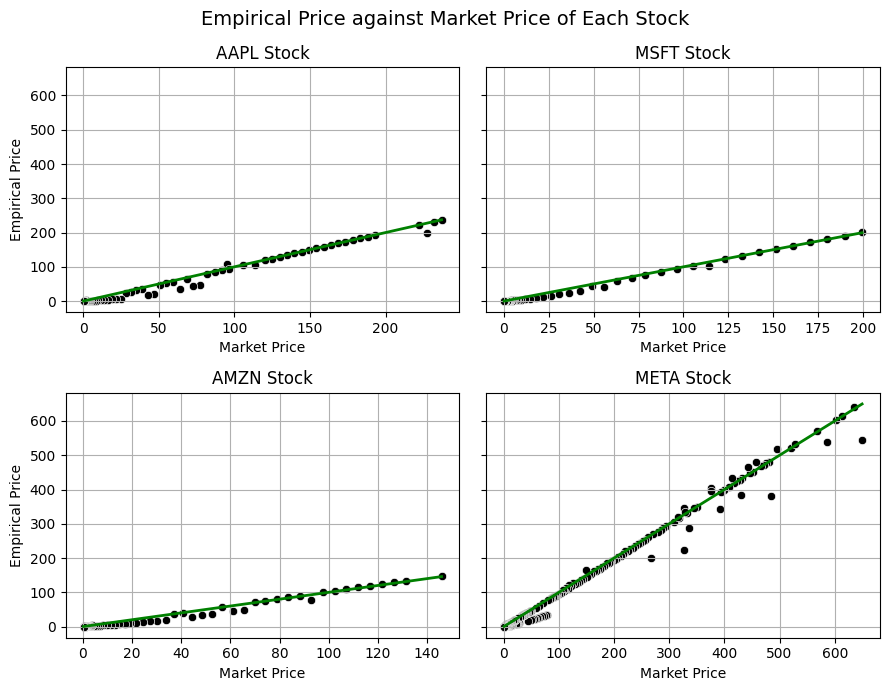

In [21]:
def visualize_price_against_market(col):
  stocks = ["AAPL", "MSFT", "AMZN", "META"]
  fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 7), sharey=True)
  fig.suptitle(f"{col} against Market Price of Each Stock", fontsize=14)

  axes = axes.flatten()
  for ax, stock in zip(axes, stocks):
      subset = calls_df[calls_df["Stock_Abbv"] == stock]  # Filter data for current stock
      sns.scatterplot(data=subset, x="Market Price", y=col, ax=ax, color="black")
      x_vals = np.linspace(subset["Market Price"].min(), subset["Market Price"].max(), 100)
      ax.plot(x_vals, x_vals, color="green", linestyle="-", linewidth=2)  # Solid green line

      # Titles and labels
      ax.set_title(f"{stock} Stock")
      ax.set_xlabel("Market Price")
      ax.set_ylabel(f"{col}")
      ax.grid(True)

  plt.tight_layout()
  plt.show()

visualize_price_against_market("Empirical Price")

As seen above, the Black-Scholes model performs well in estimating call option prices for Apple, Microsoft, and Amazon, with most points being close to the y=x line in green, which represents perfect estimations. There is more variation for Meta stock, but the estimations remain reasonably accurate.

However, let us take a look at Nvidia.

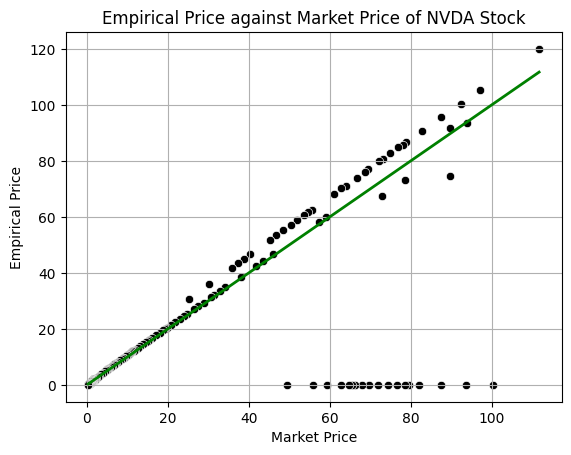

In [22]:
nvda_calls = calls_df[calls_df["Stock_Abbv"] == "NVDA"]
plot1 = sns.scatterplot(data=nvda_calls, x="Market Price", y="Empirical Price", color="black")
x_vals = np.linspace(nvda_calls["Market Price"].min(), nvda_calls["Market Price"].max(), 100)  # Generate x values
plot1.plot(x_vals, x_vals, color="green", linestyle="-", linewidth=2)  # Solid green line
plot1.set(title="Empirical Price against Market Price of NVDA Stock")
plot1.grid(True)

Notice the cluster of points near the bottom, where the model estimates the options' prices to be close to zero, even though the actual market price is \$45 and above. To investigate why this was happening, the points were colored according to their strike price $K$, as seen below:

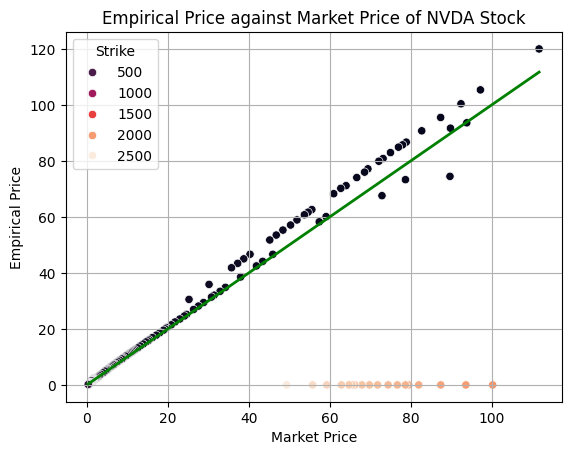

In [23]:
plot2 = sns.scatterplot(data=nvda_calls, x="Market Price", y="Empirical Price", hue="Strike", palette="rocket")
plot2.plot(x_vals, x_vals, color="green", linestyle="-", linewidth=2)  # Solid green line
plot2.set(title="Empirical Price against Market Price of NVDA Stock")
plot2.grid(True)

Notice that the points near the bottom all have extremely high strike prices, implying that the model struggles to accurately estimate prices for options with high strike prices.

This issue arises from using historical volatility for the Black-Scholes Equation, which assumes that the volatility of a call option solely depends on the price fluctuations of its underlying stock. However, in reality, call option volatility is also influenced by strike price as well. This is why options are typically priced using implied volatility, which is obtained by solving for the volatility of similar call options on the market.

### RQ4: How can European call options be priced using **implied volatility**, and how does it differ from using **historical volatility**?

Next, we price the same call options using the given `Implied Volatility` within the dataset, and compare its estimation of call option prices compared to using `Historical Volatility`.

In [24]:
calls_df["Implied Price"] = calls_df.apply(
    lambda row: calc_call_option_price(row["Stock Price"], row["Strike"], row["Months to Exp"] / 12, r_cont, row["Implied Volatility"]), axis=1
)

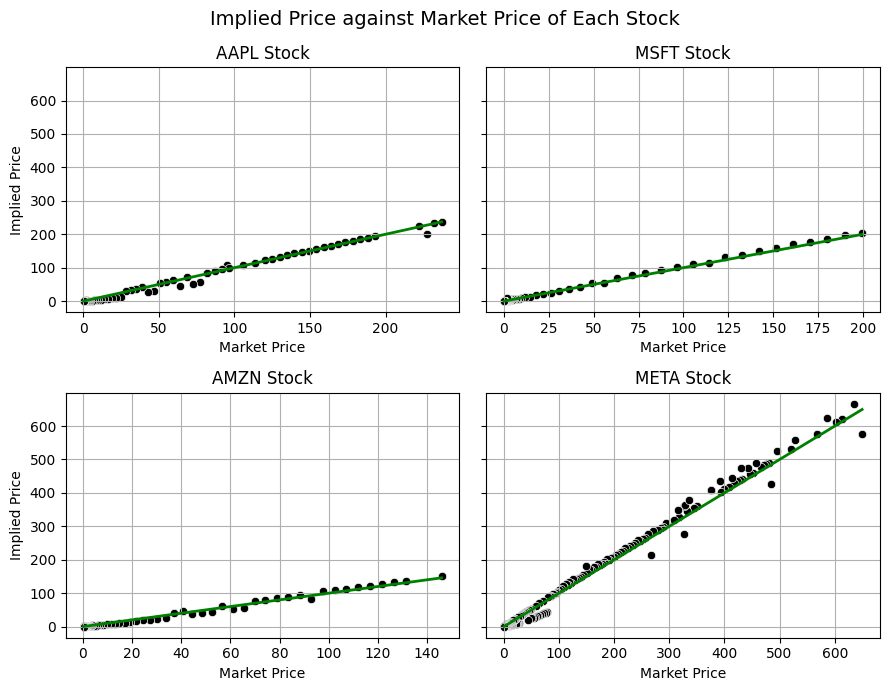

In [25]:
visualize_price_against_market("Implied Price")

Visually, we see that estiamtions for Apple, Microsoft and Amazon call options are slightly better, with points being closer to the y=x line. Estimations are Meta stock appear to be significantly better, with fewer points being far away from the y=x line.

Next, let us inspect the new estimations for Nvidia call options.

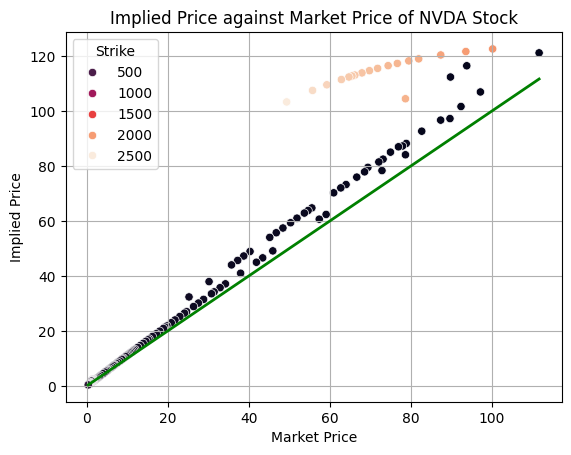

In [26]:
nvda_calls_2 = calls_df[calls_df["Stock_Abbv"] == "NVDA"]
plot3 = sns.scatterplot(data=nvda_calls_2, x="Market Price", y="Implied Price", hue="Strike", palette="rocket");
plot3.plot(x_vals, x_vals, color="green", linestyle="-", linewidth=2)  # Solid green line
plot3.set(title="Implied Price against Market Price of NVDA Stock")
plot3.grid(True)

From the above plot, we observe a slight change in the model's estimations for options with low strike prices, where it now overestimates the prices of all call options, as indicated by all the points being above the y=x line.  

Furthermore, the estimations of call options with higher strike prices are now above the y=x line, rather than being near the bottom as before. In addition, the gap between the estimated and market prices of these options are much smaller now, indicating that the model now aligns more closely with the market, than it did before.

Despite this improvement, it is worth noting that these options with unusually high strike prices may serve purposes other than trading. This could explain why the Black-Scholes model struggles to predict their prices accurately, since it assumes that the primary purpose of options is for trading.

### RQ5: Is the volatility smile observable in real-world call options?

A volatility smile illustrates patterns in implied volatility when pricing financial options. In theory, it forms a U-shape when plotting strike price against implied volatility, resembling a smile.

To determine whether this shape exists within `calls_df`, `Strike Price` will be plotted against `Implied Volatility`.

In [27]:
# remove options that expire in 9 months since that group only has 4 observations
calls_df_plot = calls_df[calls_df["Months to Exp"] != 9]
groups = calls_df_plot.groupby("Months to Exp")

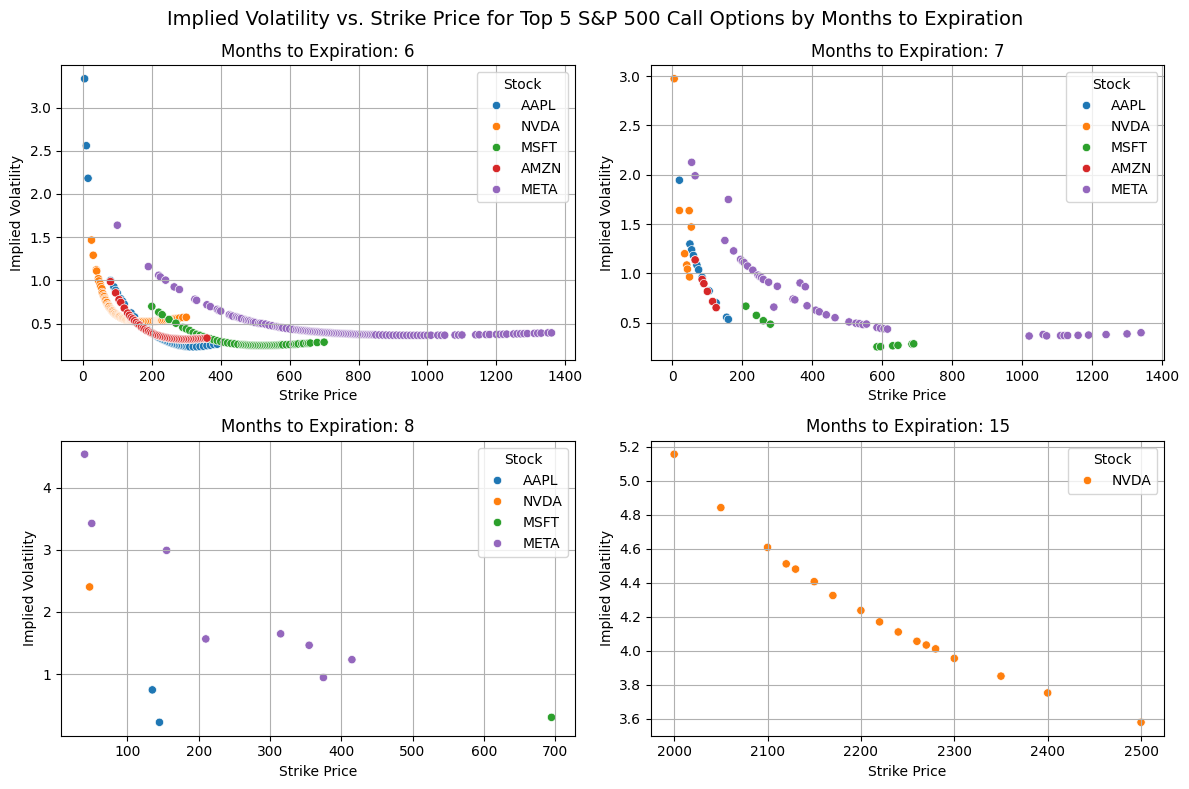

In [28]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle("Implied Volatility vs. Strike Price for Top 5 S&P 500 Call Options by Months to Expiration", fontsize=14)

palette = sns.color_palette("tab10", len(stocks))
color_mapping = dict(zip(stocks, palette))

axes = axes.flatten()
for ax, (month, group) in zip(axes, groups):
    if month == 15:
        group = group.iloc[1:]  # remove outlier to zoom into the visual
    ax.grid(True)
    sns.scatterplot(ax=ax, x="Strike", y="Implied Volatility", data=group, hue="Stock_Abbv", palette=color_mapping)
    ax.set_title(f"Months to Expiration: {month}")
    ax.set_xlabel("Strike Price")
    ax.set_ylabel("Implied Volatility")
    ax.legend(title="Stock")
plt.tight_layout()

The following observations can be made from the plot above:
1. Stocks from different companies exhibit their own volatility smile, which can be most evidently seen in the top left plot.
1. All four plots show an exponential decrease, resembling the first half of a U-shape or a theorectical volatility smile.
1. As time to expiration increases, the shape of the scatterplot becomes less curved, and more linear.
